# Working with Titanic dataset

In this notebook, I will go through the whole process of creating a machine learning model on the famous Titanic dataset. It provides information on the fate of passengers on the Titanic, summarized according to their economic status, cabin displacement, age, and sex.

This notebook was submitted as a homework for (BIE-VZD) Data Mining course, while I was studying at Faculty of Information Technoloogies of Czech Technical University in Prague. The dataset has also been provided by univeristy, though similar dataset can be found at kaggle.com.

In [1]:
#import modules
import numpy as np
import os
import pandas as pd
import seaborn as sns
import re
import random
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
#read data.csv
dataset = pd.read_csv('data.csv')
eval_data = pd.read_csv('evaluation.csv')

Let's get some information about how our dataset looks like

In [3]:
#Shape of the dataset and first 5 rows
display(dataset.shape)
dataset.head(3)

(1000, 13)

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.05,NaN,S,"England Oglesby, IL"
1,1,1,2,"Smith, Miss. Marion Elsie",female,40.0,0,0,31418,13.00,NaN,S,NaN
2,2,0,3,"Hegarty, Miss. Hanora ""Nora""",female,18.0,0,0,365226,6.75,NaN,Q,NaN


In [4]:
#Data structure
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        797 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       1000 non-null   float64
 10  cabin      226 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  554 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


There's a total of 1000 rows, but features **age**, **cabin**, **embarked**, and **home.dest** have some empty values. Let's get some numbers about survived ones

In [5]:
dataset.survived.value_counts()

0    607
1    393
Name: survived, dtype: int64

As we can see, overall probability of surviving is ~39%.

### Notes on the initial observation of data:
- Feature **embarked** has only two missing values, we can probably fill them ourselves with the most common values.
- Feature **home.dest** has 446 values missing, but this data is needless, since it won't affect chances of survival in any way. We will drop this column.
- Feature **age** has 203 values missing, so we will have to tackle this.
- Feature **cabin** has 774 missing values.

## Part 1. Data Preprocessing

### Splitting the dataset into train, test, and validation sets.

In [6]:
Xdata = dataset.drop('survived' ,axis =1)
Ydata = dataset.survived

In [7]:
SEED = 323
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xdata, Ydata, test_size=0.25, random_state=SEED)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=SEED)

In [8]:
datasets = [dataset, Xtrain, Xtest, Xval, eval_data]

### Missing Data

### Cabin

When observing values in Cabin column one can see that values look like C67, E126, meaning the letter refers to the deck. We’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero. Below you can see the actual decks of the titanic, ranging from A to G.

In [9]:
for d in datasets:
    d.loc[:,'cabin'] = d.loc[:,'cabin'].fillna("U0") #for NaNs
    d.loc[:,'deck'] = d.loc[:,'cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

In [10]:
#creating decks and converting them to numeric values
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 0}
for d in datasets:
    d.loc[:,'deck'] = d.loc[:,'deck'].map(deck)
    d.loc[:,'deck'] = d.loc[:,'deck'].fillna(0)
    d.loc[:,'deck'] = d.loc[:,'deck'].astype(int)

Now that we have decks, we can drop cabin

In [11]:
for d in datasets:
    d.drop('cabin',axis=1,inplace=True)

### Age
To fill missing values we will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and is_null.


In [12]:
for d in datasets:
    mean = d.loc[:,"age"].mean()
    std = d.loc[:,"age"].std()
    
    d.loc[:,'age'] = d.loc[:,'age'].map(lambda x: random.uniform(mean-std,mean+std))
    d.loc[:,"age"] = d.loc[:,"age"].astype(int)

### Embarked

Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [13]:
dataset['embarked'].describe()

count     998
unique      3
top         S
freq      691
Name: embarked, dtype: object

In [14]:
# S is the most common

for d in datasets:
    d['embarked'].fillna('S',inplace=True)

### Home.dest

Unnecessary feature, does not contribute to survival. Drop it

In [15]:
for d in datasets:
    d.drop('home.dest', axis = 1, inplace=True)

In [16]:
dataset.isnull().sum()

ID          0
survived    0
pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
embarked    0
deck        0
dtype: int64

### Converting features into numeric

### Name
We don't need the actual names, but the titles might be a useful piece of information.

In [17]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for d in datasets:
    # extract titles
    d['title'] = d.name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # replace titles with a more common title or as Rare
    d['title'] = d['title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
    d['title'] = d['title'].replace('Mlle', 'Miss')
    d['title'] = d['title'].replace('Ms', 'Miss')
    d['title'] = d['title'].replace('Mme', 'Mrs')
    
    # convert titles into numbers
    d['title'] = d['title'].map(titles)
    
    # filling NaN with 0, to get safe
    d['title'] = d['title'].fillna(0)
    
    d.drop(['name'], axis=1,inplace=True)

### Sex

In [18]:
genders = {"male": 1, "female": 0}

for d in datasets:
    d['sex'] = d['sex'].map(genders)

### Ticket

In [19]:
dataset['ticket'].describe()

count        1000
unique        740
top       CA 2144
freq            7
Name: ticket, dtype: object

This feature has too many unique values. Drop it

In [20]:
for d in datasets:
    d.drop(['ticket'], axis=1,inplace=True)

### Embarked

In [21]:
ports = {"S": 0, "C": 1, "Q": 2}

for d in datasets:
    d['embarked'] = d['embarked'].map(ports)

### Combining sibsp and parch

In [22]:
for d in datasets:
    d['relatives'] = d['sibsp'] + d['parch']
    d.drop('parch' , axis =1, inplace=True)
    d.drop('sibsp' , axis =1, inplace=True)

### Fare per person

Some rows in Fare feature are counting money paid for relatives' tickets as well. Let's correct this

In [23]:
for d in datasets:
    d['fare'] = d['fare'].fillna(0)
    d['fare_per_person'] = d['fare']/(d['relatives']+1)
    d['fare_per_person'] = d['fare_per_person'].astype(int)
    d.drop('fare' , axis =1, inplace=True)

### Categorizing Age
There're too many unique values for age, so it is better to categorize it.

In [24]:
for d in datasets:
    d['age'] = d['age'].astype(int)
    d.loc[ d['age'] <= 11, 'age'] = 0
    d.loc[(d['age'] > 11) & (d['age'] <= 18), 'age'] = 1
    d.loc[(d['age'] > 18) & (d['age'] <= 27), 'age'] = 2
    d.loc[(d['age'] > 27) & (d['age'] <= 40), 'age'] = 3
    d.loc[(d['age'] > 40) & (d['age'] <= 66), 'age'] = 4
    d.loc[ d['age'] > 66, 'age'] = 5

Now that the data is ready to be fed to model, let's move on to model training

## Part 2. Model Training

### Model 1. Decision Tree

In [25]:
dt = DecisionTreeClassifier()
dt.fit(Xtrain, Ytrain)

DecisionTreeClassifier()

In [26]:
ypredicted = dt.predict(Xtrain)
(Ytrain - ypredicted).value_counts(normalize=True)

0    1.0
Name: survived, dtype: float64

In [36]:
metrics.accuracy_score(Ytrain, dt.predict(Xtrain))

1.0

### Hyper Parameter Tuning - Parameter Grid



In [37]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,31), 
    'criterion': ['entropy', 'gini'],
    'random_state': [323]
}
param_comb = ParameterGrid(param_grid)

In [38]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth = params['max_depth'], criterion = params['criterion'])
    dt.fit(Xtrain, Ytrain)
    train_acc.append(metrics.accuracy_score(Ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(Yval, dt.predict(Xval)))
    

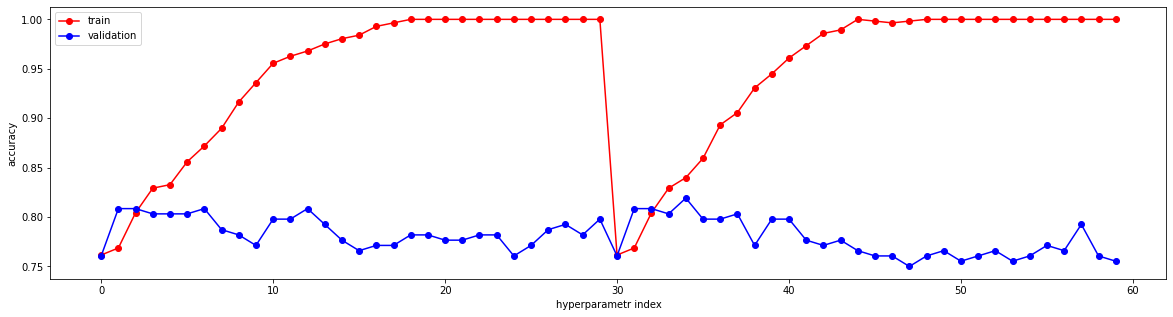

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [40]:
best_params = param_comb[np.argmax(val_acc)]
print(best_params)

print('The Training accuracy after Hyperparameter Tuning')
final_acc_score_dt = train_acc[np.argmax( train_acc)]
print(train_acc[np.argmax( train_acc)])

print('The Validation accuracy after Hyperparameter Tuning')
print(val_acc[np.argmax(val_acc)])

{'random_state': 323, 'max_depth': 5, 'criterion': 'gini'}
The Training accuracy after Hyperparameter Tuning
1.0
The Validation accuracy after Hyperparameter Tuning
0.8191489361702128


In [44]:
dt = DecisionTreeClassifier(**best_params)
dt.fit(Xtrain,Ytrain)

#final_acc_score_dt = metrics.accuracy_score(ytrain, dt.predict(Xtrain))
final_acc_score_dt_val = metrics.accuracy_score(Yval, dt.predict(Xval))

print('accuracy score (train): {0:.3f}'.format(final_acc_score_dt))
print('accuracy score (validation): {0:.3f}'.format(final_acc_score_dt_val))

print('\nFinal Model Decision Tree Accuracy Score on Validation Data is:')
print('{0:.3f}'.format(final_acc_score_dt_val))

final_acc_score_dt_test = metrics.accuracy_score(Ytest, dt.predict(Xtest))
print('\n \nFinal Real World accuracy based on test set is:')
print('{0:.3f}'.format(final_acc_score_dt_test))

accuracy score (train): 1.000
accuracy score (validation): 0.819

Final Model Decision Tree Accuracy Score on Validation Data is:
0.819

 
Final Real World accuracy based on test set is:
0.820


### Cross Validation scores

In [46]:
dt = DecisionTreeClassifier(**best_params)
scores = cross_val_score(dt, dataset.drop('survived' , axis = 1), dataset.survived , cv=10, scoring = "accuracy")
print("Scores:", scores)
print("\nMean:", scores.mean())
print("\nStandard Deviation:", scores.std())

Scores: [0.45 0.82 0.81 0.78 0.85 0.8  0.77 0.82 0.8  0.7 ]

Mean: 0.76

Standard Deviation: 0.11009087155618308


### Model 2. Random Forest Classifier

In [53]:
rf = RandomForestClassifier()
rf.fit(Xtrain, Ytrain)

yprediction = rf.predict(Xtest)

In [54]:
final_acc_score_rf = rf.score(Xtrain, Ytrain)
final_acc_score_rf_val = rf.score(Xval, Yval)
display(final_acc_score_rf)
display(final_acc_score_rf_val)

1.0

0.8191489361702128

### Hyper Parameter Tuning

In [56]:
param_grid = {
    'n_estimators': range(1, 200, 9),
    'max_depth': range(1, 10),
    'criterion': ['gini' , 'entropy'],
    'random_state':  [4532]
}

param_comb = ParameterGrid(param_grid)
train_metric = []
val_metric = []
for params in param_comb:
    rf = RandomForestClassifier(**params).fit(Xtrain, Ytrain)
    train_metric.append(metrics.accuracy_score(Ytrain, rf.predict(Xtrain)))
    val_metric.append(metrics.accuracy_score(Yval, rf.predict(Xval)))

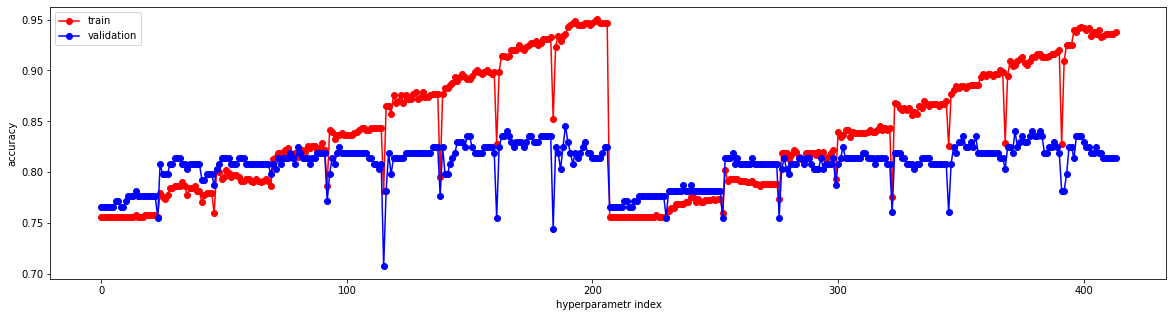

In [57]:
plt.figure(figsize=(20,5))
plt.plot(train_metric,'or-')
plt.plot(val_metric,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [58]:
best_params = param_comb[np.argmax(val_metric)]
print(best_params)
print(val_metric[np.argmax(val_metric)])
print(train_metric[np.argmax(train_metric)])

{'random_state': 4532, 'n_estimators': 46, 'max_depth': 9, 'criterion': 'gini'}
0.8457446808510638
0.9501779359430605


In [60]:
rf = RandomForestClassifier(**best_params) 
rf.fit(Xtrain, Ytrain)
final_acc_score_rf = metrics.accuracy_score(Ytrain, rf.predict(Xtrain))
final_acc_score_rf_val = metrics.accuracy_score(Yval, rf.predict(Xval))
final_acc_score_rf_test = metrics.accuracy_score(Ytest, rf.predict(Xtest))



print('accuracy score (train) after hyper parameter tuning: {0:.3f}'.format(final_acc_score_rf))
print('accuracy score (validation): {0:.3f}'.format(final_acc_score_rf_val))

print('\n \nFinal Model Random Forest Accuracy Score on Validation Data is:')
print('{0:.3f}'.format(final_acc_score_rf_val))

print('\n \nFinal Real World accuracy based on test set is:')
print('{0:.3f}'.format(final_acc_score_rf_test))

accuracy score (train) after hyper parameter tuning: 0.936
accuracy score (validation): 0.846

 
Final Model Random Forest Accuracy Score on Validation Data is:
0.846

 
Final Real World accuracy based on test set is:
0.796


## Final
Random forest has higher score on validation set, so it is a better option to choose for evaluating evaluation.csv

### Predicting values on evaluation.csv

In [61]:
predictions_eval_data = rf.predict(eval_data)
results = pd.DataFrame({'ID':eval_data.index, 'Survived':predictions_eval_data})
results.to_csv('results2.csv')